<a href="https://colab.research.google.com/github/mggg/Computational-Tools-Workshop-2026/blob/main/prefsampling_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prefsampling

# Prefsampling tutorial: sampling cultures, Euclidean elections, and multiwinner rules

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from prefsampling import ordinal as pref
from prefsampling.point import ball_uniform, cube, gaussian
from prefsampling.core.euclidean import EuclideanSpace

plt.rcParams.update({'figure.dpi': 120})
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


## Helper functions

In [ ]:
def ranks_from_votes(votes, m):
    n = len(votes)
    ranks = np.empty((n, m), dtype=int)
    for i, vote in enumerate(votes):
        for r, c in enumerate(vote):
            ranks[i, c] = r
    return ranks

def borda_scores_matrix(votes, m):
    ranks = ranks_from_votes(votes, m)
    scores = (m - 1) - ranks
    return ranks, scores

def borda_winner(votes, m):
    _, scores = borda_scores_matrix(votes, m)
    totals = scores.sum(axis=0)
    return int(np.argmax(totals)), totals

def borda_multiwinner(votes, m, k):
    _, scores = borda_scores_matrix(votes, m)
    totals = scores.sum(axis=0)
    # Return top-k candidates by total score (descending)
    return list(np.argsort(-totals)[:k]), totals

def greedy_cc(votes, m, k):
    # Greedy Chamberlin-Courant with Borda satisfaction
    _, scores = borda_scores_matrix(votes, m)
    selected = []
    current = np.zeros(scores.shape[0], dtype=float)
    for _ in range(k):
        best_c, best_gain = None, -1
        for c in range(m):
            if c in selected:
                continue
            new = np.maximum(current, scores[:, c])
            gain = new.sum() - current.sum()
            if gain > best_gain:
                best_gain = gain
                best_c = c
        selected.append(best_c)
        current = np.maximum(current, scores[:, best_c])
    return selected

def greedy_harmonic_borda(votes, m, k):
    # Greedy Harmonic Borda: sequentially maximize HB objective
    ranks, scores = borda_scores_matrix(votes, m)
    n = len(votes)
    selected = []

    def hb_utility_for_voter(selected_set, v):
        # Selected candidates ordered by this voter's preference
        if not selected_set:
            return 0.0
        ordered = sorted(selected_set, key=lambda c: ranks[v, c])
        util = 0.0
        for i, c in enumerate(ordered, start=1):
            util += scores[v, c] / i
        return util

    current_util = np.array([0.0] * n)

    for _ in range(k):
        best_c, best_gain = None, -1
        for c in range(m):
            if c in selected:
                continue
            gain = 0.0
            candidate_set = selected + [c]
            for v in range(n):
                new_u = hb_utility_for_voter(candidate_set, v)
                gain += new_u - current_util[v]
            if gain > best_gain:
                best_gain = gain
                best_c = c
        selected.append(best_c)
        # Update utilities after selecting best_c
        for v in range(n):
            current_util[v] = hb_utility_for_voter(selected, v)
    return selected

In [ ]:
def kendall_tau_distance(v1, v2):
    # Count inversions between two rankings
    pos = {c: i for i, c in enumerate(v1)}
    p = [pos[c] for c in v2]
    inv = 0
    for i in range(len(p)):
        for j in range(i + 1, len(p)):
            if p[i] > p[j]:
                inv += 1
    return inv

def embed_votes_mds(votes, seed=7):
    n = len(votes)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i + 1, n):
            d = kendall_tau_distance(votes[i], votes[j])
            D[i, j] = D[j, i] = d
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=seed)
    return mds.fit_transform(D)


In [ ]:

def plot_vote_map(votes, title='Vote map (MDS)', radius=None, coloring_func=None):
    # Count duplicates and keep a single representative vote for plotting.
    from collections import Counter
    counts = Counter(tuple(v) for v in votes)
    unique_votes = [list(v) for v in counts.keys()]

    coords = embed_votes_mds(unique_votes)
    
    if coloring_func is None:
        # colors = [v[0] for v in unique_votes]
        colors = 'blue'
    else:
        colors = [coloring_func(v) for v in unique_votes]
        
    avg_x = np.mean(coords[:, 0])
    avg_y = np.mean(coords[:, 1])

    # Scale point sizes by identical vote counts so duplicates stand out.
    base_size = 20
    sizes = [base_size * counts[tuple(v)] for v in unique_votes]

    fig, ax = plt.subplots(figsize=(3, 3))

    if radius is not None:
        # Compute integer axis bounds explicitly to satisfy static analyzers.
        xmin = int(avg_x - radius)
        xmax = int(avg_x + radius)
        ymin = int(avg_y - radius)
        ymax = int(avg_y + radius)
        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    else:
        # Add a bit of white margin when radius isn't specified.
        ax.margins(0.25)

    ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)
    ax.axis('off')
    ax.set_title(title)
    return fig, ax



In [ ]:

def plot_election_2d(voters_pos, candidates_pos, votes=None, title=''):
    if votes is None:
        colors = 'gray'
    else:
        colors = [v[0] for v in votes]
    plt.figure(figsize=(5, 5))
    plt.scatter(voters_pos[:, 0], voters_pos[:, 1], c='tab:gray', cmap='tab20', s=25, alpha=0.1, label='voters')
    plt.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='black', s=120, marker='X', label='candidates')
    for i, (x, y) in enumerate(candidates_pos):
        plt.text(x, y, str(i), fontsize=9, ha='center', va='center', color='white')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.tight_layout()

def plot_candidates_2d(candidates_pos, title='', ax=None, annotate=True, label=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='black', s=120, marker='X', label=label or 'candidates')
    if annotate:
        for i, (x, y) in enumerate(candidates_pos):
            ax.text(x, y, str(i), fontsize=9, ha='center', va='center', color='white')
    if title:
        ax.set_title(title)
    ax.legend(loc='upper right')
    return ax

In [ ]:
def plot_election_2d(voters_pos, candidates_pos, votes=None, title=''):
    if votes is None:
        colors = 'gray'
    else:
        colors = [v[0] for v in votes]
    plt.figure(figsize=(5, 5))
    plt.scatter(voters_pos[:, 0], voters_pos[:, 1], c='tab:gray', cmap='tab20', s=25, alpha=0.1, label='voters')
    plt.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='blue', s=50, marker='o', alpha=0.33, label='candidates')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()

def plot_candidates_2d(candidates_pos, title='', ax=None, annotate=True, label=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='black', s=120, marker='X', label=label or 'candidates')
    if annotate:
        for i, (x, y) in enumerate(candidates_pos):
            ax.text(x, y, str(i), fontsize=9, ha='center', va='center', color='white')
    if title:
        ax.set_title(title)
    ax.legend(loc='upper right')
    return ax


In [ ]:
def sample_euclidean(num_voters, num_candidates, num_dimensions, voters_sampler, candidates_sampler, **kwargs):
    voters_pos = voters_sampler(num_voters, num_dimensions, **kwargs.get('voters_args', {}))
    cand_pos = candidates_sampler(num_candidates, num_dimensions, **kwargs.get('candidates_args', {}))
    votes = pref.euclidean(
        num_voters,
        num_candidates,
        num_dimensions,
        voters_pos,
        cand_pos,
    )
    return voters_pos, cand_pos, votes

# 2D: voters uniform in cube, candidates from a 2-Gaussian mixture
def gaussian_mixture(num_points, num_dimensions, centers, sigmas, weights=None, seed=None):
    centers = np.array(centers, dtype=float)
    if len(centers) != len(sigmas):
        raise ValueError('centers and sigmas must have the same length')
    if weights is None:
        weights = np.ones(len(centers), dtype=float) / len(centers)
    weights = np.array(weights, dtype=float)
    weights = weights / weights.sum()
    rng = np.random.default_rng(seed)
    counts = rng.multinomial(num_points, weights)
    parts = []
    for count, center, sigma in zip(counts, centers, sigmas):
        if count == 0:
            continue
        parts.append(
            gaussian(
                count,
                num_dimensions,
                center_point=center,
                sigmas=sigma,
                seed=int(rng.integers(0, 1_000_000_000)),
            )
        )
    if not parts:
        candidates_pos = np.empty((0, num_dimensions))
    else:
        candidates_pos = np.vstack(parts)
    return candidates_pos


## Classic statistical cultures (IC, urn, Mallows)

In [ ]:
n, m = 100, 8

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)


(<Figure size 360x360 with 1 Axes>, <Axes: title={'center': 'IC vote map'}>)

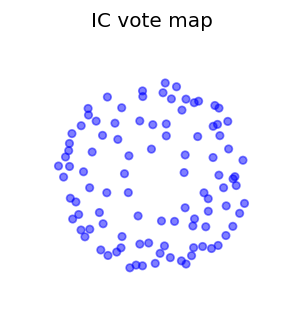

In [ ]:
votes_ic = pref.impartial(n, m)
plot_vote_map(votes_ic, 'IC vote map')

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)


(<Figure size 360x360 with 1 Axes>,
 <Axes: title={'center': 'Urn model (alpha=0.75)'}>)

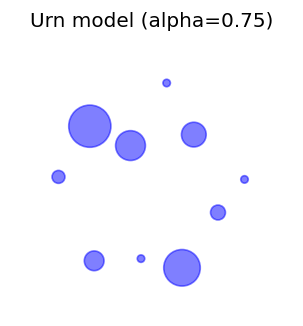

In [ ]:
alpha = 0.75
votes_urn = pref.urn(n, m, alpha=alpha)
plot_vote_map(votes_urn, f'Urn model (alpha={alpha})')

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)
/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)
/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)


(<Figure size 360x360 with 1 Axes>,
 <Axes: title={'center': 'Mallows (phi=0.5)'}>)

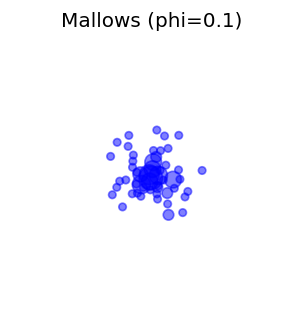

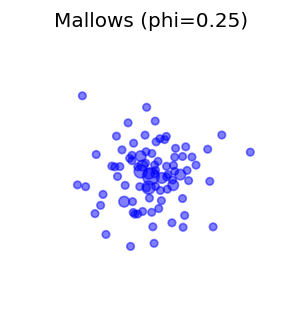

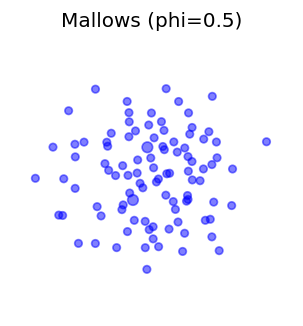

In [ ]:
votes_mallows = pref.mallows(n, m, phi=0.2)
plot_vote_map(votes_mallows, 'Mallows (phi=0.1)', radius=16)
votes_mallows = pref.mallows(n, m, phi=0.4)
plot_vote_map(votes_mallows, 'Mallows (phi=0.25)', radius=16)
votes_mallows = pref.mallows(n, m, phi=0.6)
plot_vote_map(votes_mallows, 'Mallows (phi=0.5)', radius=16)

## Structured domains: single-peaked and group-separable
For larger sizes these may be slower. Start small and scale up if time allows.

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)
/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)


(<Figure size 360x360 with 1 Axes>,
 <Axes: title={'center': 'Single-peaked (Conitzer)'}>)

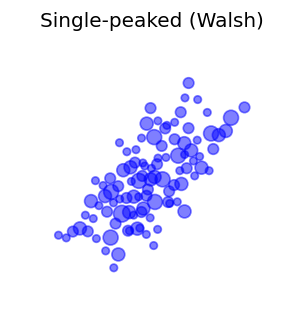

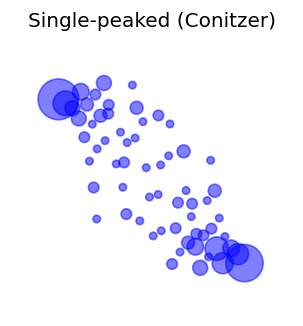

In [ ]:
n, m = 200, 8
votes_sp_w = pref.single_peaked_walsh(n, m, seed=11)

votes_sp_c = pref.single_peaked_conitzer(n, m, seed=11)

plot_vote_map(votes_sp_w, 'Single-peaked (Walsh)')
plot_vote_map(votes_sp_c, 'Single-peaked (Conitzer)')

Optional Task 1

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)


(<Figure size 360x360 with 1 Axes>, <Axes: title={'center': 'Single-Peaked'}>)

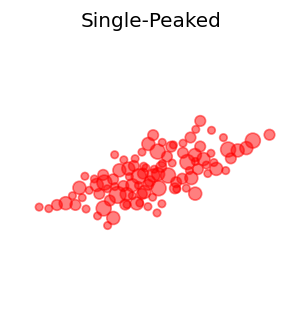

In [ ]:
def my_coloring_func(vote):
    return 'red' # CHANGE THIS LINE
    
votes_sp_w = pref.single_peaked_walsh(n, m, seed=11)
plot_vote_map(votes_sp_w, 'Single-Peaked', radius=16, coloring_func=my_coloring_func)
    

## Mixtures of Mallows models

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/1251070287.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(coords[:, 0], coords[:, 1], c=colors, cmap='tab20', s=sizes, alpha=0.5)


(<Figure size 360x360 with 1 Axes>,
 <Axes: title={'center': 'Mixture of Mallows models'}>)

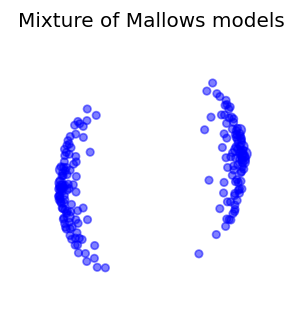

In [ ]:
from prefsampling.core import concatenation

votes = concatenation(
    [100, 100],  # num_voters per sampler
    10,  # num_candidates
    [pref.mallows, pref.mallows],  # list of samplers
    [{'phi': 0.33, 'central_vote': [0,1,2,3,4,5,6,7,8,9]}, 
     {'phi': 0.33, 'central_vote': [9,8,7,6,5,4,3,2,1,0]}]  # parameters of the samplers
)

plot_vote_map(votes, 'Mixture of Mallows models')


## 2D-Euclidean elections 2D
We generate positions for voters and candidates, then sample ordinal preferences.

/var/folders/l_/7g11f6g137b6zhdlhl87l0p40000gn/T/ipykernel_46823/3590125604.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(voters_pos[:, 0], voters_pos[:, 1], c='tab:gray', cmap='tab20', s=25, alpha=0.1, label='voters')


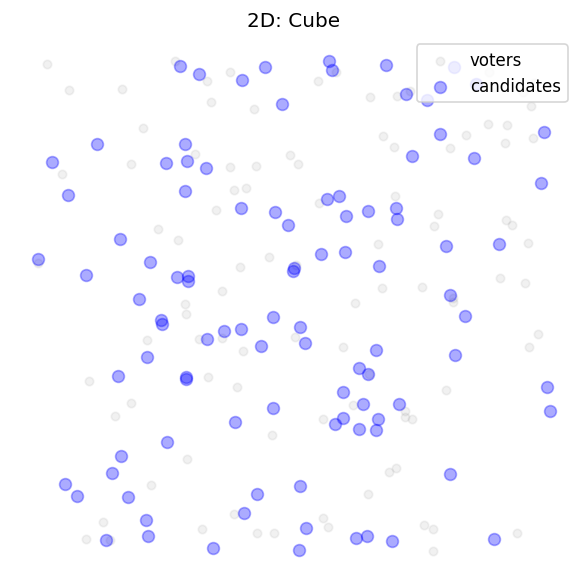

In [ ]:
# 2D: voters in a ball, candidates in a wider cube
v2, c2, votes2 = sample_euclidean(100, 100, 2, cube, cube,
                                 voters_args={'widths': 1.0},
                                 candidates_args={'widths': 1.0})
plot_election_2d(v2, c2, votes2, '2D: Cube')

## Voting rules: Borda, GreedyCC, Greedy Harmonic Borda
We compare the three rules on a Euclidean election.

Borda winner: [np.int64(68), np.int64(69), np.int64(31), np.int64(89), np.int64(76), np.int64(64), np.int64(36), np.int64(62), np.int64(67), np.int64(39)]
GreedyCC committee: [68, 53, 70, 33, 25, 10, 43, 63, 18, 82]
Greedy Harmonic Borda committee: [68, 31, 76, 36, 57, 39, 0, 62, 79, 30]


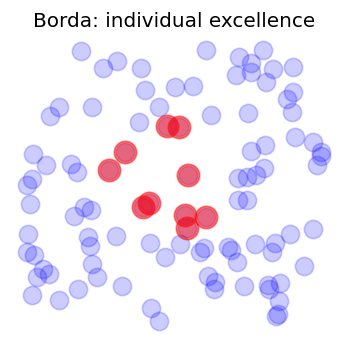

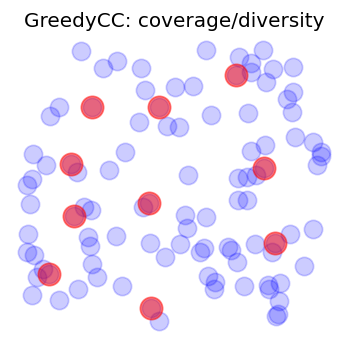

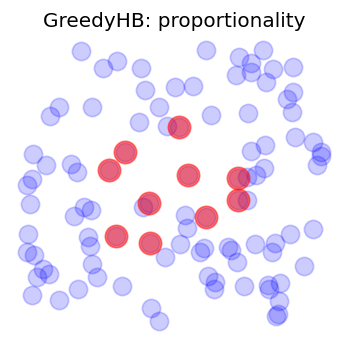

In [ ]:
m = c2.shape[0]
k = 10

borda_w, _ = borda_multiwinner(votes2, m, k)
cc_committee = greedy_cc(votes2, m, k)
hb_committee = greedy_harmonic_borda(votes2, m, k)

print('Borda winner:', borda_w)
print('GreedyCC committee:', cc_committee)
print('Greedy Harmonic Borda committee:', hb_committee)

def plot_committee(candidates_pos, committee, title):
    plt.figure(figsize=(3, 3))
    plt.scatter(candidates_pos[:, 0], candidates_pos[:, 1], c='blue', s=120, marker='o', alpha=0.2)
    sel = np.array(committee, dtype=int)
    plt.scatter(candidates_pos[sel, 0], candidates_pos[sel, 1], c='red', s=180, marker='o', alpha=0.5)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()

plot_committee(c2, [borda_w], 'Borda: individual excellence')
plot_committee(c2, cc_committee, 'GreedyCC: coverage/diversity')
plot_committee(c2, hb_committee, 'GreedyHB: proportionality')


In [ ]:
# Memory for overlay plots
X = []
Y = []
cc_winners = []
hb_winners = []
borda_winners = []

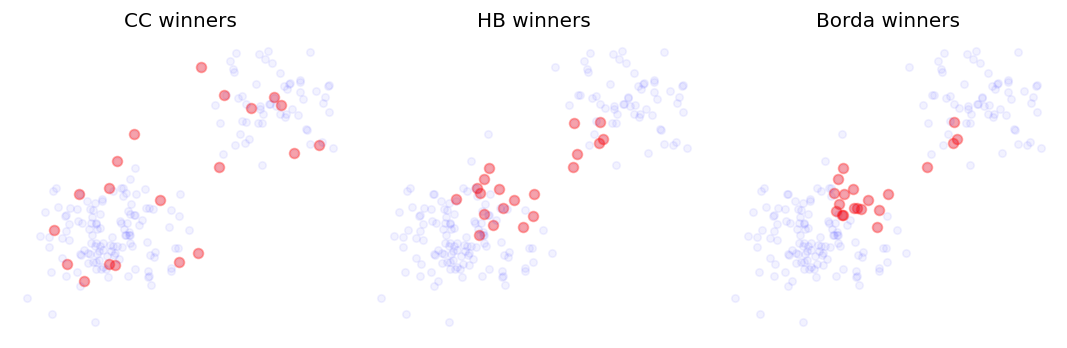

In [ ]:
# Generate multiple elections and store winner sets for overlays
centers = [[-0.25, -0.25], [0.25, 0.25]]
sigmas = [0.12, 0.12]
weights = [0.7, 0.3]

v_new, c_new, votes_new = sample_euclidean(
    100, 100, 2, cube, gaussian_mixture,
    voters_args={'widths': 1.0},
    candidates_args={
        'centers': centers,
        'sigmas': sigmas,
        'weights': weights,
    },
)

m_new = c_new.shape[0]
committee_size = 10
cc_committee_new = greedy_cc(votes_new, m_new, committee_size)
hb_committee_new = greedy_harmonic_borda(votes_new, m_new, committee_size)
borda_committee_new, _ = borda_multiwinner(votes_new, m_new, committee_size)

X.append(c_new[:, 0])
Y.append(c_new[:, 1])
cc_winners.append(cc_committee_new)
hb_winners.append(hb_committee_new)
borda_winners.append(borda_committee_new)

def plot_winners(winners, ax=None, title=''):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    else:
        fig = ax.figure

    for i in range(len(X)):
        ax.scatter(X[i], Y[i], c='blue', s=20, marker='o', alpha=0.05)
        ws = winners[i]
        ax.scatter(X[i][ws], Y[i][ws], c='red', s=35, marker='o', alpha=0.33)
    # ax.legend(['candidates', 'cc committee'], loc='upper right')
    ax.axis('off')
    if title:
        ax.set_title(title)
    fig.tight_layout()
    return fig, ax
    
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_winners(cc_winners, ax=axes[0], title='CC winners')
plot_winners(hb_winners, ax=axes[1], title='HB winners')
plot_winners(borda_winners, ax=axes[2], title='Borda winners')
plt.tight_layout()
